# Language Identification Model


In [6]:
### TO DEBUGGIN'
DEBUG = True

## Load Package

In [55]:
# to load and manipulate data
import pandas as pd
import numpy as np
import os
import time

# to make neural netowrk model, sequencing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# para el modelo classic (non-customized)
from tensorflow import keras
from keras import Sequential

# to evaluate and display results
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# to graph
import squarify

## Setting hyperparameters


In [26]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 512  # Number of rows used in each iteration
    EPOCHS = 12  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 64
    EPOCHS = 1 #12

## Load Data

In [27]:
## print paths
for root, dirs, files in os.walk('./data'):
    for filename in files:
        print(os.path.join(root,filename))

del dirs
del root
del files
del filename

./data/language.json
./data/sentences.csv


In [28]:
%%time
df = pd.read_csv("./data/sentences.csv")

CPU times: user 5.54 s, sys: 479 ms, total: 6.02 s
Wall time: 6.14 s


## Data Cleansing

In [29]:
## drop ID column
df.drop(columns=['id'],inplace=True)
df.head()

,lan_code,sentence
0,cmn,我們試試看！
1,cmn,我该去睡觉了。
2,cmn,你在干什麼啊？
3,cmn,這是什麼啊？
4,cmn,今天是６月１８号，也是Muiriel的生日！


In [30]:
if DEBUG:
    display(df.describe())

,lan_code,sentence
count,10341812,10341812
unique,404,10330761
top,eng,Bravo!
freq,1586621,11


Code LANGUAGE with less frequency than 10: sentence    277
dtype: int64


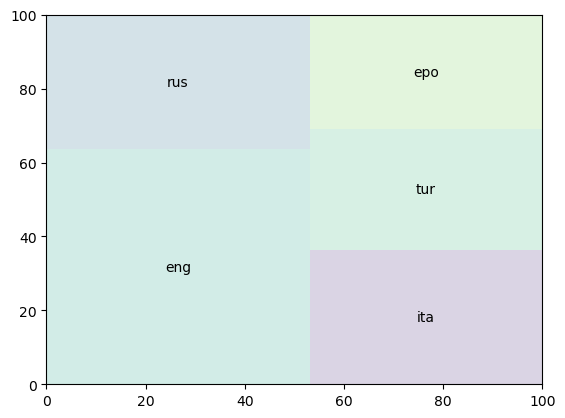

In [31]:
if DEBUG:
    df_exploration = df.groupby("lan_code").count().sort_values("sentence",ascending = False)

    #!# posiblemente cuando se entrene el modelo los de baja frecuencia no va a predecir correctamente
    #!# como posible opcion 1 analizar con todo y luego ver el impacto de remover esos code lan con freq 1
    
    count_freq_1 = df_exploration[df_exploration.sentence<=10].sum()
    print("Code LANGUAGE with less frequency than 10: {}".format(count_freq_1))
    
    ## GRAPH - TREEMAP
    # top 50 Language with more sentences
    sizes_treemap = df_exploration["sentence"][:5].tolist()
    labels_treemap = df_exploration[:5].index.values.tolist()
    
    #plt.figure(figsize=(10,10))
    squarify.plot(sizes = sizes_treemap, label = labels_treemap, alpha=0.2)
    plt.savefig('/Users/pitehrhurtadocayo/Documents/DevOps/Project_0006_NLP/NLP_LanguageIdentification/outputs/heatmap_lan.png')
    plt.show()
    #list_lan_top_10 = df_exploration[:5].index.tolist()
    list_lan_top_10 = ['eng','spa']
    del df_exploration
    del count_freq_1
    del sizes_treemap
    del labels_treemap

## Preprocessing Data


In [32]:
## Filter TOP 5 Lan
df = df[df["lan_code"].isin(list_lan_top_10)] 

if DEBUG:
    print(df.describe())
# ENCODING CLASSES (cod language)
classes_list = list(df.lan_code.unique())
print("Count of Classes: {}".format(len(classes_list)))

       lan_code                                    sentence
count   1956462                                     1956462
unique        2                                     1956440
top         eng  I care very deeply for you, she confessed.
freq    1586621                                           2
Count of Classes: 2


In [33]:
## crearemos dos dic para usos posteriores de transformacion
cls_to_num = {
    cls : i
    for i,cls in enumerate(classes_list)
}

num_to_cls = {
    i : cls
    for cls,i in cls_to_num.items()
}
del classes_list

In [34]:
## cambiar el string-code por int-code para ingresarlos al modelo
display(df.head())
df.lan_code = df.lan_code.map(cls_to_num).astype(int)
display(df[df["lan_code"]==1])

,lan_code,sentence
1232,eng,Let's try something.
1233,eng,I have to go to sleep.
1235,eng,Today is June 18th and it is Muiriel's birthday!
1236,eng,Muiriel is 20 now.
1237,eng,"The password is ""Muiriel""."


,lan_code,sentence
2393,1,¡Intentemos algo!
2394,1,Tengo que irme a dormir.
2395,1,¿Qué estás haciendo?
2396,1,¿Qué es eso?
2397,1,¡Hoy es 18 de junio y es el cumpleaños de Muir...
...,...,...
10341807,1,Quiero este libro por favor.
10341808,1,Los han hecho huir.
10341809,1,Los botaron.
10341810,1,Los hicieron correr.


## Subset Train & Test

In [35]:
# Lista de Sentencias
X = df.pop('sentence').values

# Lista de CODE LAN 
y = df.copy().values.T[0]

if DEBUG:
    display(X)
    display(y)

array(["Let's try something.", 'I have to go to sleep.',
       "Today is June 18th and it is Muiriel's birthday!", ...,
       'Los botaron.', 'Los hicieron correr.', 'Los corrieron.'],
      dtype=object)

array([0, 0, 0, ..., 1, 1, 1])

In [36]:
## liberamos memoria virtual (RAM)
del df

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    train_size=0.8,
    random_state=50,
    shuffle = True
)

## liberamos memoria virtual (RAM)
del X, y

NameError: name 'X' is not defined

# Tokenization

Usaremos este metodo para procesar los datos input para el modelo:

mas info: https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4


### Sentencias -> Secuencias de palabras


In [39]:
## parameters for preprocessing
# number of language samples per language that we will extract from source files
NUM_WORDS = 100000

# Length of cleaned text used for training and prediction - 100 chars
MAX_LEN = 1000 ##

NUM_CLASSES = 2 # esto lo sacamos de arriba

In [40]:
def tokenize_and_sequence(train_sentences,test_sentences):
    tok = Tokenizer(num_words = NUM_WORDS,
                    split = ' ',
                    oov_token='<OOV>')
    tok.fit_on_texts(train_sentences)
    
    # training set
    train_seq = tok.texts_to_sequences(train_sentences)
    #max_len=max([len(i) for i in train_seq])
    train_seq = pad_sequences(
                    train_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    
    # testing set
    test_seq = tok.texts_to_sequences(test_sentences)
    test_seq = pad_sequences(
                    test_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    if DEBUG:
        print("PADD TRAIN:")
        print(train_sentences[:2])
        print(train_seq[:2])
        print("PADD TEST:")
        print(test_sentences[:2])
        print(test_seq[:2])
        print("TOK: --info--")
        print(tok.get_config()['word_counts'])
    
    return train_seq, test_seq, tok

In [41]:
%%time
X_train, X_test, tok = tokenize_and_sequence(X_train, X_test)

# WARNING: problemas de tiempo de respuesta, se debe cambiar la config del notebook

PADD TRAIN:
['¡Qué rápido corre la Srta. Kanda!' "Why shouldn't Tom be in Australia?"]
[[1354 1411 4831 ...    0    0    0]
 [  84  368    2 ...    0    0    0]]
PADD TEST:
['Sois dos años más jóvenes que Tom.'
 'Tom intends to stay in Australia for three weeks.']
[[4764  436  530 ...    0    0    0]
 [   2 5498    3 ...    0    0    0]]
TOK: --info--
{"\u00a1qu\u00e9": 784, "r\u00e1pido": 748, "corre": 148, "la": 63436, "srta": 2, "kanda": 14, "why": 21229, "shouldn't": 3860, "tom": 365099, "be": 69868, "in": 121101, "australia": 10666, "did": 30829, "you": 190004, "wash": 892, "your": 31535, "face": 2589, "this": 61941, "morning": 4227, "has": 38558, "crooked": 32, "teeth": 666, "i": 278833, "was": 106738, "afraid": 4013, "that": 230927, "might": 7829, "do": 119996, "she's": 7787, "always": 9133, "careful": 1532, "isn't": 23448, "she": 66098, "hay": 4964, "alguien": 1284, "en": 41587, "sala": 258, "contigua": 8, "glasses": 928, "are": 54095, "all": 26228, "steamed": 24, "up": 21111, 

In [42]:
if DEBUG:
    print(X_train.shape)
    print(X_test.shape)

(1565169, 1000)
(391293, 1000)


# Model NLP

## Build Model

- Embedding layer son capas de palabras previamente entrenadas como GloVe, se usan mucho en NLP.
- LSTM : capa de memoria a largo plazo
- Dense: capa densa conectada normal
- Dropout: ayuda a evitar el sobreajuste en la entrada

Funciones de Activacion: https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6

Ocupamos:
- ReLu
- Softmax: se usa muy amenudo en la ultima capa de la red, como FA. dado que el resultado se podria interpretar como una D. P. 

In [43]:
def builtModel(vocad_dim = NUM_WORDS, max_len = MAX_LEN, num_classes = NUM_CLASSES):
    model = Sequential()
    
    ## ADD LAYERS
    model.add(layers.Embedding(input_dim=vocad_dim,
                              output_dim=32,
                              input_length=max_len))
    model.add(layers.LSTM(units=32,
                         return_sequences=False,
                         activation='relu'))
    model.add(layers.Dense(units=1,
                          activation="sigmoid"))
    
    #compiler
    model.compile(loss='binary_crossentropy',
                  optimizer ='adam',
                  metrics=['accuracy'])
    return model

In [44]:
nlpModel = builtModel()
nlpModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 32)          3200000   
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,208,353
Trainable params: 3,208,353
Non-trainable params: 0
_________________________________________________________________


## Train Model OR Load Model

### train model:

In [28]:
%%time
history = nlpModel.fit(
                    X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS
)

24456/24456 [==============================] - 9909s 405ms/step - loss: nan - accuracy: 0.8110 - val_loss: nan - val_accuracy: 0.8110
CPU times: user 1h 34min 51s, sys: 8min 18s, total: 1h 43min 9s
Wall time: 2h 45min 9s


In [31]:
## Training INFO
history.history
nlpModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          3200000   
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,208,353
Trainable params: 3,208,353
Non-trainable params: 0
_________________________________________________________________


In [32]:
nlpModel.save('/Users/pitehrhurtadocayo/Documents/DevOps/Project_0006_NLP/NLP_LanguageIdentification/models/temp/')

INFO:tensorflow:Assets written to: /Users/pitehrhurtadocayo/Documents/DevOps/Project_0006_NLP/NLP_LanguageIdentification/models/temp/assets


In [33]:
nlpModel.save_weights('/Users/pitehrhurtadocayo/Documents/DevOps/Project_0006_NLP/NLP_LanguageIdentification/models/model.h5')

### load model:

In [45]:
with open('model.json') as json_file:
    json_config = json_file.read()
nlpModel = keras.models.model_from_json(json_config)
nlpModel.load_weights('model.h5')
nlpModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 32)          3200000   
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,208,353
Trainable params: 3,208,353
Non-trainable params: 0
_________________________________________________________________


## Evaluate Model

In [24]:
def predictModel(model, sentences):
    y_pred = model.predict(sentences, batch_size=BATCH_SIZE, verbose=1)
    y_pred = y_pred.argmax(axis=1)
    return y_pred

In [63]:
%%time
result = predictModel(model,X_test)

6114/6114 [==============================] - 261s 43ms/step
CPU times: user 4min 29s, sys: 16 s, total: 4min 45s
Wall time: 4min 21s


In [65]:
result

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
%%time
acc = accuracy_score(y_test, result)
conf_mat = confusion_matrix(y_test, result)
conf_mat_recall = confusion_matrix(y_test, result, normalize='true')
conf_mat_precision = confusion_matrix(y_test, result, normalize='pred')

CPU times: user 121 ms, sys: 11.4 ms, total: 133 ms
Wall time: 134 ms


### Accuracy

In [67]:
print(f"Accuracy = {acc:.2%}")

Accuracy = 81.10%


In [85]:
for layer in nlpModel.layers:
    print(layer.name, layer)

print(nlpModel.layers[2].weights)
#print(nlpModel.layers[0].bias.numpy())
#print(nlpModel.layers[0].bias_initializer)

embedding_7 <keras.layers.core.embedding.Embedding object at 0x3222dcd60>
lstm_7 <keras.layers.rnn.lstm.LSTM object at 0x323abf0d0>
dense_7 <keras.layers.core.dense.Dense object at 0x323abe410>
[<tf.Variable 'dense_7/kernel:0' shape=(32, 1) dtype=float32, numpy=
array([[ 0.28560817],
       [-0.2497101 ],
       [-0.2230534 ],
       [ 0.34591103],
       [-0.3439625 ],
       [ 0.03220358],
       [ 0.3025226 ],
       [ 0.39177758],
       [ 0.19075781],
       [ 0.27232122],
       [ 0.19602525],
       [-0.3397117 ],
       [ 0.2895167 ],
       [-0.1032134 ],
       [-0.17523748],
       [-0.3748114 ],
       [-0.25979263],
       [-0.08643642],
       [-0.2318564 ],
       [ 0.4138288 ],
       [ 0.29965717],
       [ 0.22743738],
       [ 0.16102713],
       [-0.08243582],
       [-0.21181934],
       [-0.02583426],
       [ 0.33789498],
       [ 0.21587384],
       [-0.07155055],
       [-0.014943  ],
       [-0.19197735],
       [-0.0110108 ]], dtype=float32)>, <tf.Variable 'd

# Test

In [83]:
phrase = ["Hello world friends"]
tok = Tokenizer(num_words = NUM_WORDS,
                    split = ' ',
                    oov_token='<OOV>')
print(tok.fit_on_texts(phrase))
    
    # training set
sequence = tok.texts_to_sequences(phrase)
    #max_len=max([len(i) for i in train_seq])
sequence = pad_sequences(
                    sequence,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post')
print(sequence)



None
[[2 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [84]:
nlpModel = builtModel()
result = predictModel(nlpModel,sequence)
print(result)

1/1 [==============================] - 0s 76ms/step
[0]


# Anexos

## confusion matrix

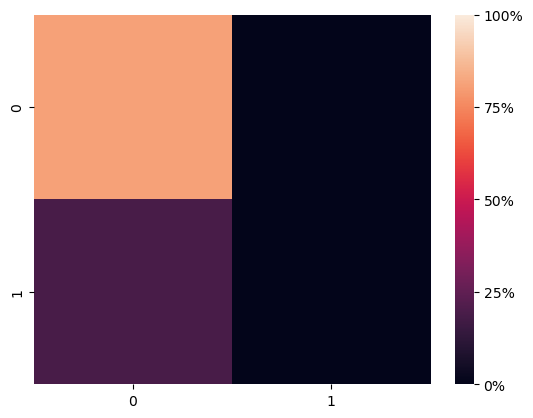

In [57]:
#plt.figure(figsize=(12, 12))
ax = sns.heatmap(conf_mat_precision, vmin=0, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.show()